<h1 align="center">Introduction to Machine Learning - Course Code: 25737</h1>
<h4 align="center">Instructor: Dr. Amiri</h4>
<h4 align="center">Sharif University of Technology, Spring 2024</h4>
<h4 align="center">Computer Assignment 3</h4>
<h4 align="center">

Question 3

</h4>

# Personal Data

In [105]:
# Set your student number
student_number = 400101956
Name = 'Mohammad'
Last_Name = 'Morsali'

# Autoencoders (25 Points)

In this problem, you should implement an autoencoder network, which generates an image presenting the next digit of the input digit. Here are some examples:

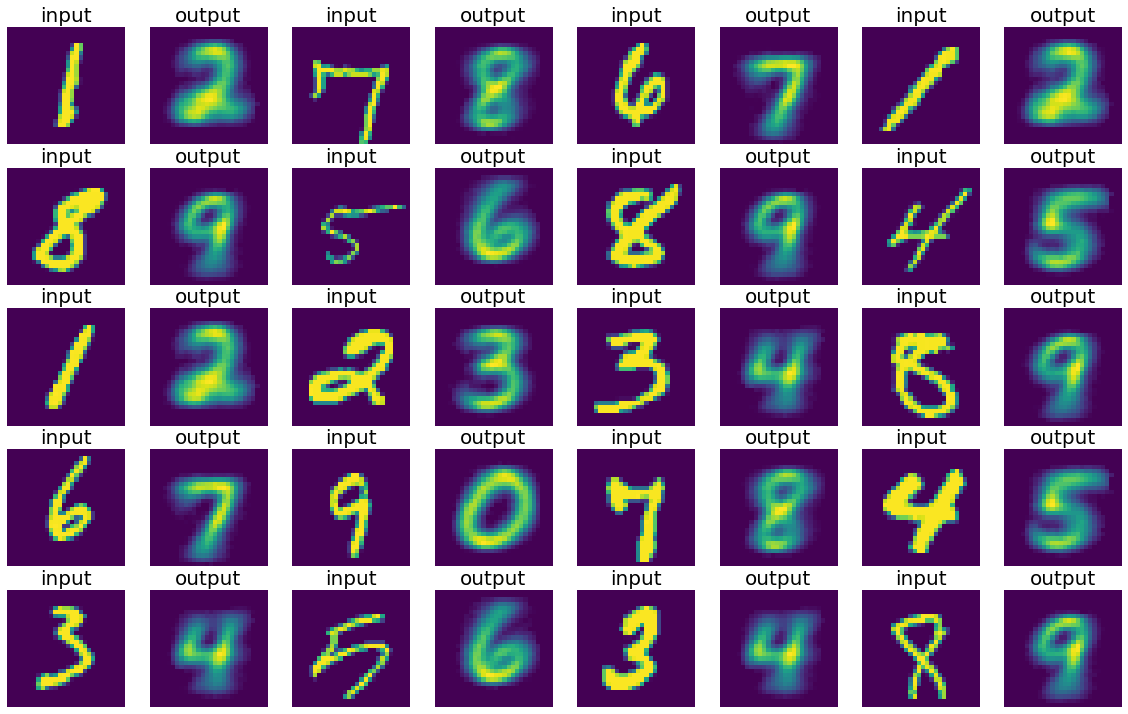

You should use the MNIST dataset, and the ground-truth for each example is provided by a helper function. Make sure to put the `ae_helper.py` file next to this notebook to use the helper function.

## Get the data

Get the data and split them into training, validation, and test sets, by running the following cell. `X` is the input images, `Y` is the ground-truth for each input, and `y` is the input's label.

In [106]:
from ae_helper import get_data
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.nn import functional as F
import os


X, Y, y = get_data()

X_train, X_test, Y_train, Y_test, y_train, y_test = train_test_split(X, Y, y, test_size=0.2, random_state=17)
X_train, X_val, Y_train, Y_val, y_train, y_val = train_test_split(X_train, Y_train, y_train, test_size=0.1, random_state=17)

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\datasets\_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


## Design your model

Please Implement your autoencoder model below. You MUST implement your model using the `torch` package. The model should input a batch of images and output the generated images for the whole batch. Your model can be consist of fully connected layers (using linear layers), but using fully-convolutional models has extra points.

In [107]:
import torch
import torch.nn as nn

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 32)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 28 * 28),
            nn.Sigmoid()
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        for layer in self.encoder:
            x = layer(x)
        
        for layer in self.decoder:
            x = layer(x)

        return x

## The dataset class, and the dataloaders

The following cells implement the dataset class and create the data loaders for training and validation sets. Feel free to modify the batch size for each data loader.

In [108]:
from typing import Tuple
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

class MnistNextDigitDataset(Dataset):
    def __init__(self, X: np.ndarray, Y: np.ndarray, y: np.ndarray):
        self.X = torch.from_numpy(X)
        self.Y = torch.from_numpy(Y)
        self.y = torch.from_numpy(y)

    def __len__(self) -> int:
        return self.X.shape[0]

    def __getitem__(self, i: int) -> Tuple[torch.Tensor, ...]:
        return self.X[i], self.Y[i], self.y[i]

In [109]:
train_dataloader = DataLoader(
    MnistNextDigitDataset(X_train, Y_train, y_train),
    batch_size=512,
    shuffle=True
)
val_dataloader = DataLoader(
    MnistNextDigitDataset(X_val, Y_val, y_val),
    batch_size=1024,
    shuffle=False
)

In [110]:
import torch.optim as optim
from torch.autograd import Variable

# Place for your custom functions for training and evaluation of the autoencoder
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def train_autoencoder(autoencoder: nn.Module, optimizer: optim.Optimizer, data_loader: DataLoader) -> float:
    autoencoder.train()
    total_loss = 0.0
    loss_function = nn.MSELoss()

    for batch_idx, (input_data, target_data, _) in enumerate(data_loader):
        input_data = input_data.view(input_data.size(0), -1).to(device)  # Flatten the input
        target_data = target_data.view(target_data.size(0), -1).to(device)  # Flatten the target

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        reconstructed = autoencoder(input_data)

        # Compute reconstruction loss (e.g., mean squared error)
        loss = loss_function(reconstructed, target_data)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * input_data.size(0)

    average_loss = total_loss / len(data_loader.dataset)

    return average_loss

def eval_autoencoder(autoencoder: nn.Module, data_loader: DataLoader) -> float:
    autoencoder.eval()
    total_loss = 0.0
    loss_function = nn.MSELoss()

    with torch.no_grad():
        for batch_idx, (input_data, target_data, _) in enumerate(data_loader):
            input_data = input_data.view(input_data.size(0), -1).to(device)  # Flatten the input
            target_data = target_data.view(target_data.size(0), -1).to(device)  # Flatten the target

            reconstructed = autoencoder(input_data)
            loss = loss_function(reconstructed, target_data)
            total_loss += loss.item() * input_data.size(0)

    average_loss = total_loss / len(data_loader.dataset)

    return average_loss

## Instantiate the model and optimizer

Instantiate your model and optimizer in the following cell. Feel free to choose the optimizer and its configurations such as learning rate, decay, etc.

In [111]:
#### INSTANTIATE YOUR MODEL AND OPTIMIZER ####
import torch_optimizer as optim
ae = AutoEncoder().to(device=device)
base_optimizer = torch.optim.Adam(ae.parameters(), lr=0.0005)
optimizer = optim.Lookahead(base_optimizer, k=5, alpha=0.5)

## Train your autoencoder

Write your training/validation loop in the following cell for an arbitrary number of epochs (until convergence is detected). Make sure to use proper and readable logging containing training and validation metrics for each epoch. Select and store the state dictionary of the best epoch model according to the metrics.

Epoch [1/10], Train Loss: 0.0878, Val Loss: 0.0596, Train Acc: 0.8459, Val Acc: 0.8459
Epoch [2/10], Train Loss: 0.0573, Val Loss: 0.0562, Train Acc: 0.8430, Val Acc: 0.8432
Epoch [3/10], Train Loss: 0.0555, Val Loss: 0.0555, Train Acc: 0.8413, Val Acc: 0.8415
Epoch [4/10], Train Loss: 0.0549, Val Loss: 0.0552, Train Acc: 0.8409, Val Acc: 0.8412
Epoch [5/10], Train Loss: 0.0545, Val Loss: 0.0551, Train Acc: 0.8403, Val Acc: 0.8406
Epoch [6/10], Train Loss: 0.0542, Val Loss: 0.0551, Train Acc: 0.8408, Val Acc: 0.8412
Epoch [7/10], Train Loss: 0.0540, Val Loss: 0.0550, Train Acc: 0.8399, Val Acc: 0.8403
Epoch [8/10], Train Loss: 0.0538, Val Loss: 0.0551, Train Acc: 0.8405, Val Acc: 0.8408
Epoch [9/10], Train Loss: 0.0535, Val Loss: 0.0552, Train Acc: 0.8403, Val Acc: 0.8407
Epoch [10/10], Train Loss: 0.0533, Val Loss: 0.0558, Train Acc: 0.8429, Val Acc: 0.8433
Best model saved with validation loss: 0.0550


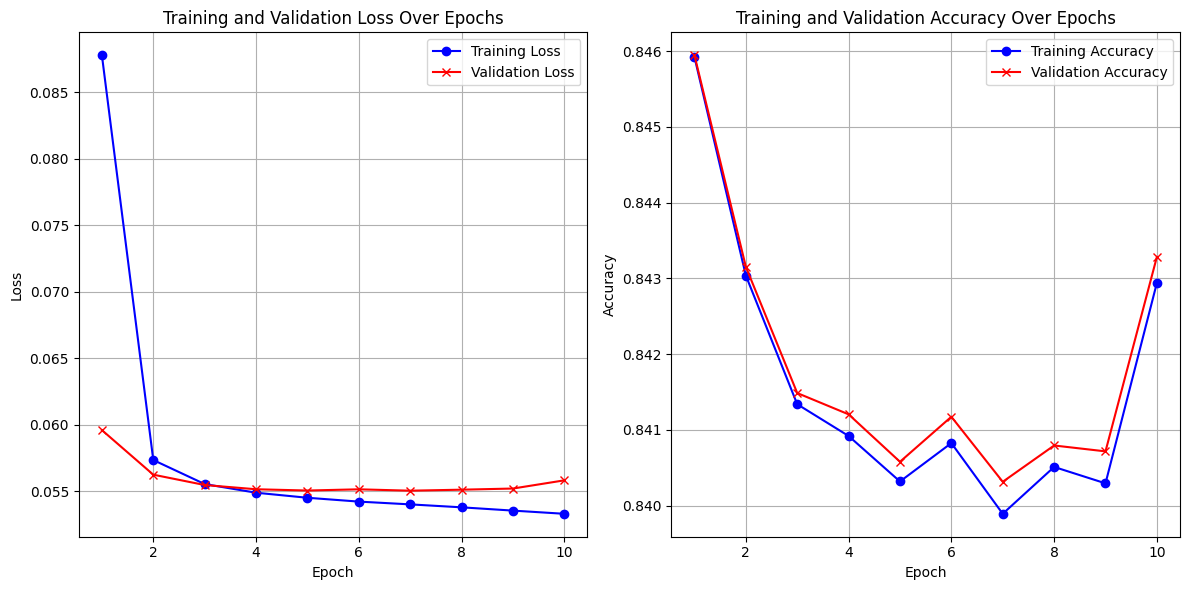

In [112]:
import torch
import os
import matplotlib.pyplot as plt

# Number of epochs
epochs = 10

# To store the best model
lowest_val_loss = float('inf')
optimal_model_weights = None

# Lists to store losses and accuracies for plotting
training_losses = []
validation_losses = []
training_accuracies = []
validation_accuracies = []

def calculate_reconstruction_accuracy(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataloader:
            inputs = data[0]
            
            # Flatten the input if necessary (modify based on your model's input requirements)
            inputs_flat = inputs.view(inputs.size(0), -1)
            
            outputs = model(inputs_flat)
            predicted = outputs.view_as(inputs)  # Reshape to the original input shape

            # Convert predictions and inputs to binary (0 or 1) if necessary
            predicted_binary = (predicted > 0.5).float()
            inputs_binary = (inputs > 0.5).float()

            total += inputs.numel()
            correct += (predicted_binary == inputs_binary).sum().item()
    return correct / total

# Training and evaluation loop
for ep in range(epochs):
    epoch_train_loss = train_autoencoder(ae, optimizer, train_dataloader)
    epoch_val_loss = eval_autoencoder(ae, val_dataloader)

    # Calculate reconstruction accuracy
    train_accuracy = calculate_reconstruction_accuracy(ae, train_dataloader)
    val_accuracy = calculate_reconstruction_accuracy(ae, val_dataloader)

    # Store losses and accuracies for plotting
    training_losses.append(epoch_train_loss)
    validation_losses.append(epoch_val_loss)
    training_accuracies.append(train_accuracy)
    validation_accuracies.append(val_accuracy)

    # Check if this is the best model so far
    if epoch_val_loss < lowest_val_loss:
        lowest_val_loss = epoch_val_loss
        optimal_model_weights = ae.state_dict()

    print(f'Epoch [{ep + 1}/{epochs}], Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}')

    # Implement early stopping logic if required
    if ep > 5 and all(validation_losses[-5] <= val for val in validation_losses[-4:]):
        print(f'Early stopping at epoch {ep + 1}')
        break

# Save the best model
if optimal_model_weights is not None:
    os.makedirs('model_checkpoints', exist_ok=True)
    torch.save(optimal_model_weights, 'autoencoder.pth')
    print(f'Best model saved with validation loss: {lowest_val_loss:.4f}')

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(training_losses) + 1), training_losses, label='Training Loss', color='blue', linestyle='-', marker='o')
plt.plot(range(1, len(validation_losses) + 1), validation_losses, label='Validation Loss', color='red', linestyle='-', marker='x')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, len(training_accuracies) + 1), training_accuracies, label='Training Accuracy', color='blue', linestyle='-', marker='o')
plt.plot(range(1, len(validation_accuracies) + 1), validation_accuracies, label='Validation Accuracy', color='red', linestyle='-', marker='x')
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('metrics_plot.png')
plt.show()


## Load the state dictionary of the best epoch

Load the state dictionary of the best epoch model into the model object.

In [113]:
#### LOAD THE BEST EPOCH STATE DICTIONARY ####
best_model_path = 'autoencoder.pth'

# Load the state dictionary into the model
ae.load_state_dict(torch.load(best_model_path))

<All keys matched successfully>

## Visualize your model

Select 40 examples from the test set and visualize the input and output of the model for them (See the examples at the beginning of the notebook).

Images shape: torch.Size([40, 784])
Targets shape: torch.Size([40, 28, 28])
Outputs shape: (40, 784)


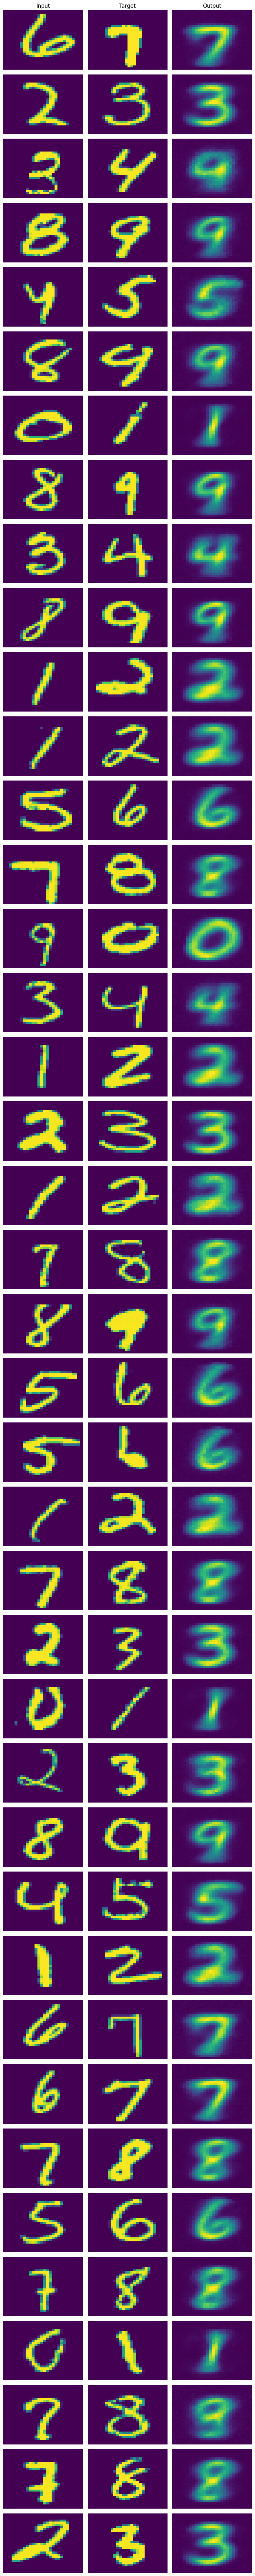

In [115]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from torch.utils.data import DataLoader

# Ensure the autoencoder is in evaluation mode
ae.eval()

# Define the test dataset and dataloader
test_dataset = MnistNextDigitDataset(X_test, Y_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=40, shuffle=True)

# Select 40 examples from the test set
dataiter = iter(test_dataloader)
images, targets, _ = next(dataiter)

# Move the images to the appropriate device and flatten them
images = images.to(device).view(-1, 784)

# Generate outputs using the autoencoder
outputs = ae(images).cpu().detach().numpy()

# Debugging: Print shapes and a few example values
print("Images shape:", images.shape)
print("Targets shape:", targets.shape)
print("Outputs shape:", outputs.shape)
#print("Example input image:", images[0])
#print("Example target image:", targets[0])
#print("Example output image:", outputs[0])

# Move images back to CPU and reshape them
images = images.cpu().view(-1, 28, 28).numpy()
targets = targets.view(-1, 28, 28).numpy()
outputs = outputs.reshape(-1, 28, 28)

# Set the figure size (width, height)
plt.figure(figsize=(8, 80))

# Plot the input, target, and output images
for i in range(40):
    # Input images
    ax = plt.subplot(40, 3, i * 3 + 1)
    plt.imshow(images[i], cmap='viridis')
    plt.axis('off')
    if i == 0:
        ax.set_title('Input', fontsize=12)
    ax.set_aspect('auto')  # Set aspect ratio to auto

    # Target images (ground truth)
    ax = plt.subplot(40, 3, i * 3 + 2)
    plt.imshow(targets[i], cmap='viridis')
    plt.axis('off')
    if i == 0:
        ax.set_title('Target', fontsize=12)
    ax.set_aspect('auto')  # Set aspect ratio to auto

    # Reconstructed output images
    ax = plt.subplot(40, 3, i * 3 + 3)
    plt.imshow(outputs[i], cmap='viridis')
    plt.axis('off')
    if i == 0:
        ax.set_title('Output', fontsize=12)
    ax.set_aspect('auto')  # Set aspect ratio to auto

plt.tight_layout()
plt.show()
